# XGBoost Regression ALL

In [78]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from pathlib import Path
import xgboost as xgb
import numpy as np
import pickle

In [79]:
data_dir = "../../preprocessed/" 
features_dir = data_dir + "regression_features/features_all/"
# labels_dir = data_dir + "labels/" 

model_dir = "../../resources/regression/" 

PCA_components = 64

USE_GEO = "GEO"

if USE_GEO == "GEO":
    features_columns = ["PCA"+str(i) for i in range(PCA_components)] + \
                        ["centroid_x", "centroid_y"]
else:
    features_columns = ["PCA"+str(i) for i in range(PCA_components)]
        

network_type = "vgg16_4096"


standardize_features = True

# feature_size = 2048

In [80]:
label_columns = ["hType_mix", "num_intersect", "bld_avg_age", "emp_rat_num",\
				"LUM5_single",	"RNR_nres", "mdist_smallparks", "nig_rat_daily",\
				"nig_rat_daily3", "mdist_nres_daily", "num_community_places", \
				"num_community_places_poi", "avg_block_area", "sphi", \
				"enterprises_empl_size", "pop_rat_num",  \
				"emp_rat_pop", "den_nres_daily",\
				"mdist_parks", "den_nres_non-daily", "mdist_railways",\
				"mdist_highways", "mdist_water", "activity_density"] # "bld_rat_area", 

In [81]:
land_use = [
"LUM5_single","RNR_nres","mdist_smallparks",
"hType_mix", "nig_rat_daily", "mdist_nres_daily",
"num_community_places", "num_community_places_poi"]


small_blocks = [
"avg_block_area","num_intersect", "sphi"]


age_buildings = [
"bld_avg_age","enterprises_empl_size"]

concentration = [
"pop_rat_num","emp_rat_num","emp_rat_pop"
    ,"den_nres_daily","den_nres_non-daily"]

vacuums = [
"mdist_parks", "mdist_railways",
"mdist_highways", "mdist_water"]

## Functions

In [82]:
def get_normalized_labels_features():
    if network_type == "vgg19":
        df = pd.read_csv(features_dir + "Italy_6_cities_vgg19_pca"+str(PCA_components)+"_linear_fc_thirdlast_layer_labels_features.csv")
    elif network_type == "resnet50":
        df = pd.read_csv(features_dir + "Italy_6_cities_resnet_pca"+str(PCA_components)+"_second_last_layer_labels_features.csv")
    elif network_type == "vgg16_4096":
        df = pd.read_csv(features_dir + "Italy_6_cities_resnet_pca" + str(PCA_components) + "_vgg16_4096_labels_features.csv")

    df["city_image"] = df.\
        apply(lambda x: x.city + "_" + x.imageName, axis = 1)
    
    del df['imageName']
    del df['city']
    del df['index']
    return df

In [115]:
def predict_label_i(label="label_activity_density"):
    
    data2 = data.copy()
    
    target = data2[["city_image", label]]
    features = data2[features_columns]
    
    X = features.values
    y = target[label].values
    
    param_dist = {'objective' :'reg:squarederror', 'n_estimators':16}
    clf = xgb.XGBRegressor(**param_dist)

    clf.fit(X, y,verbose=False)
    
    pickle.dump(clf, open(model_dir + label + '_all_reg.dat' , "wb"))
    
    print(clf.score(X, y))

In [104]:
def predict_label_i_KFold(label="label_hType_mix"):
    
    kf = KFold(n_splits=10)
    
    data2 = data.copy()
    target = data2[["city_image", label]]
    features = data2[features_columns]
    
    X = features.values
    y = target[label].values
 
    rmse = []
    r2 = []
    mae = []
    
    kf.get_n_splits(X, y)
    for train_index, test_index in kf.split(X, y):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        param_dist = {'objective' :'reg:squarederror', 'n_estimators':16}
        clf = xgb.XGBRegressor(**param_dist)
        
        clf.fit(X_train, y_train,verbose=False)
        
        predictions = clf.predict(X_test)
        rmse1 = np.sqrt(mean_squared_error(y_test, predictions))
        rmse.append(rmse1)
        
        r21 = r2_score(y_test, predictions)
        r2.append(r21)
        
        mae1 = mean_absolute_error(y_test, predictions)
        mae.append(mae1)
        
    pickle.dump(clf, open(model_dir + label + 'reg.dat' , "wb"))

        
    return  ({"MAE": (np.mean(mae), np.std(mae)), \
              "R2": (np.mean(r2), np.std(r2)), "RMSE": (np.mean(rmse), np.std(rmse))},
             {"RMSE": np.mean(rmse), "R2": np.mean(r2)})

## Read in Data. Chose standardized or not.

In [105]:
data = get_normalized_labels_features()

## Predict K-Fold

In [106]:
data[['label_activity_density']].describe()

,label_activity_density
count,1069.000000
mean,0.430750
std,0.253064
min,0.000000
25%,0.250571
50%,0.389735
75%,0.604387
max,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122f45590>]],
      dtype=object)

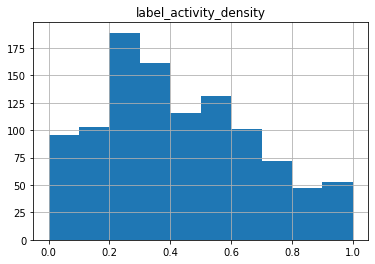

In [107]:
data[['label_activity_density']].hist()

In [108]:
len(data)

1069

In [109]:
predict_label_i_KFold('label_activity_density')

({'MAE': (0.136544545116192, 0.016168049195507857),
  'R2': (0.49455264968198226, 0.13941135387621903),
  'RMSE': (0.17246784650284208, 0.017976239146148557)},
 {'RMSE': 0.17246784650284208, 'R2': 0.49455264968198226})

In [110]:
kfold_SCORES = {}
kfold_SCORES2 = {}
for col in label_columns:
    label = "label_" + col
    res1, res2 = predict_label_i_KFold(label)
    kfold_SCORES[label] = res1
    kfold_SCORES2[label] = res2

In [111]:
kfold_SCORES

{'label_hType_mix': {'MAE': (0.16464687845083206, 0.038801316991812725),
  'R2': (0.07825073236547501, 0.1560002798788519),
  'RMSE': (0.21656011505368733, 0.04823399387551757)},
 'label_num_intersect': {'MAE': (0.16871404397713477, 0.02059937569330191),
  'R2': (0.34529667565812416, 0.1531926830472858),
  'RMSE': (0.21262483208234245, 0.020624232694663635)},
 'label_bld_avg_age': {'MAE': (0.14568694749741287, 0.030522653503057422),
  'R2': (0.3317893145325467, 0.1356886494547223),
  'RMSE': (0.18401976387290234, 0.031417992354588364)},
 'label_emp_rat_num': {'MAE': (0.13940889206067866, 0.015196325084643945),
  'R2': (0.37288304815019935, 0.11374843052005178),
  'RMSE': (0.17681984719722207, 0.019767953807788497)},
 'label_LUM5_single': {'MAE': (0.17752238744606824, 0.022138469021401964),
  'R2': (0.07465689234605613, 0.12332683716272068),
  'RMSE': (0.22143547370014435, 0.02655929281900886)},
 'label_RNR_nres': {'MAE': (0.20609541088656846, 0.021582967850984694),
  'R2': (0.032516949

In [112]:
res = pd.DataFrame(kfold_SCORES2)

In [113]:
res

,label_hType_mix,label_num_intersect,label_bld_avg_age,label_emp_rat_num,label_LUM5_single,label_RNR_nres,label_mdist_smallparks,label_nig_rat_daily,label_nig_rat_daily3,label_mdist_nres_daily,...,label_enterprises_empl_size,label_pop_rat_num,label_emp_rat_pop,label_den_nres_daily,label_mdist_parks,label_den_nres_non-daily,label_mdist_railways,label_mdist_highways,label_mdist_water,label_activity_density
R2,0.078251,0.345297,0.331789,0.372883,0.074657,0.032517,0.137911,0.015851,0.255015,0.390613,...,0.006308,0.315522,0.040608,0.386588,-0.047223,0.452848,0.235836,0.217076,0.065481,0.494553
RMSE,0.216560,0.212625,0.184020,0.176820,0.221435,0.257972,0.205111,0.199139,0.176767,0.200071,...,0.252168,0.225143,0.213256,0.205759,0.238111,0.175065,0.231574,0.241001,0.240895,0.172468


In [116]:
for col in label_columns:
    label = "label_" + col
    print (label)
    predict_label_i(label)

label_hType_mix
0.9487700500007821
label_num_intersect
0.9473266446861077
label_bld_avg_age
0.954876288982297
label_emp_rat_num
0.9548015353346029
label_LUM5_single
0.9511053440749179
label_RNR_nres
0.9268265419930063
label_mdist_smallparks
0.9390535822034097
label_nig_rat_daily
0.9507069076087643
label_nig_rat_daily3
0.9801373638249734
label_mdist_nres_daily
0.9554530881187406
label_num_community_places
0.9689972047144527
label_num_community_places_poi
0.9193001126943625
label_avg_block_area
0.9555608453198436
label_sphi
0.940142834777484
label_enterprises_empl_size
0.9355753722003464
label_pop_rat_num
0.9436667573561243
label_emp_rat_pop
0.9435869996129436
label_den_nres_daily
0.9665156675764326
label_mdist_parks
0.8841542397805993
label_den_nres_non-daily
0.9682335179139471
label_mdist_railways
0.9430093434924365
label_mdist_highways
0.9512884165026639
label_mdist_water
0.9021339888916419
label_activity_density
0.9667860593453459


In [14]:
if standardize_features:
    out_name = '../../results/XGBoost/ALL_XGBoost' +str(PCA_components)\
            + '_' + network_type + '_' + USE_GEO + '_standardized7s.csv'
else:
    out_name = '../../results/XGBoost/ALL_XGBoost' +str(PCA_components)\
       + '_' + network_type + '_' + USE_GEO +   '7s.csv'
res.to_csv(out_name, float_format='%.3f')

In [15]:
res_dir = '../../results/XGBoost/ALL_' + network_type + '_' + USE_GEO +"_" + str(PCA_components)
Path(res_dir).mkdir(parents=True, exist_ok=True)

In [16]:
land_use_cols = ["label_"+l for l in land_use]
res_land_use = res[land_use_cols]

In [17]:
small_blocks_cols = ["label_"+l for l in small_blocks]
res_small_blocks = res[small_blocks_cols]

In [18]:
age_buildings_cols = ["label_"+l for l in age_buildings]
res_age_buildings = res[age_buildings_cols]

In [19]:
concentration_cols = ["label_"+l for l in concentration]
res_concentration = res[concentration_cols]

In [20]:
vacuums_cols = ["label_"+l for l in vacuums]
res_vacuums = res[vacuums_cols]

In [21]:
for out_cat_name in ["land_use", "small_blocks", \
                     "age_buildings", "concentration",
                    "vacuums"]:
    eval("res_" + out_cat_name).to_csv(res_dir + "/res_" + out_cat_name+\
                                       ".csv", float_format='%.3f')